## Model Prediction Test

In [9]:
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

import numpy as np
import os
import glob
import cv2
from collections import Counter
import random


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 5.0)

def resize_image(image, shape = (500, 500)):
    resized_image = cv2.resize(image, shape)
    return resized_image


def label_one_hot_encoding(labe_list):
    encoder = LabelEncoder()
    transfomed_label = encoder.fit_transform(labe_list)
    one_hot_encoded_labels =  np_utils.to_categorical(transfomed_label)
    one_hot_label_dict = {}
    for i  in range(len(labe_list)):
        one_hot_label_dict[labe_list[i]] = one_hot_encoded_labels[i] 
    
    print("one hot encoding: ", one_hot_label_dict)
    return one_hot_label_dict


def load_samples(DATA_PATH, one_hot_encoding_dict):
    labels = one_hot_encoding_dict.keys()    
    samples = [] # [one_hot_label, image_path]
    temp_size = 0
    for dir in DATA_PATH: 
        print("loading data from: " + dir)
        for key in labels:           
            samples += [[one_hot_encoding_dict[key],file] for file in glob.glob(os.path.join(dir, key + '*.jpg'))]
            temp_size = len(samples) - temp_size    
            print("total " + str(temp_size) + " " + key + " images loaded.")
            temp_size = len(samples)
        
        print("total " + str(temp_size) + " raw data samples loaded.")
        
    return samples  


LABEL_LIST = ["dog", "cat"]
TRAIN_DATA_PATH_LIST = ["./train"]

model = load_model("dog_vs_cat_model.h5")

one_hot_encoding_dict = label_one_hot_encoding(LABEL_LIST)
print("label encoding is done.", one_hot_encoding_dict)
    
raw_samples = load_samples(TRAIN_DATA_PATH_LIST, one_hot_encoding_dict)
print("raw sample loaded.")


one hot encoding:  {'cat': array([ 1.,  0.]), 'dog': array([ 0.,  1.])}
label encoding is done. {'cat': array([ 1.,  0.]), 'dog': array([ 0.,  1.])}
loading data from: ./train
total 12500 cat images loaded.
total 12500 dog images loaded.
total 25000 raw data samples loaded.
raw sample loaded.


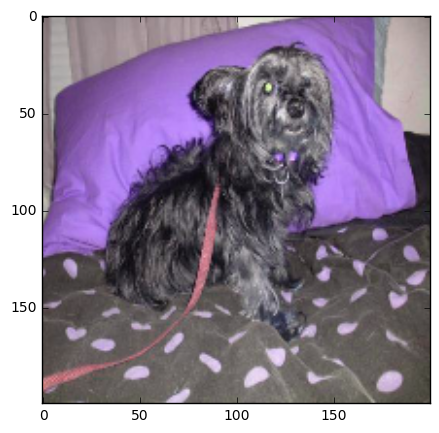

(200, 200, 3)
(1, 200, 200, 3)


array([[ 0.00028345,  0.02508481]], dtype=float32)

In [20]:


img = cv2.imread(raw_samples[12500][1])
img = resize_image(img, (200, 200))
plt.imshow(img)
plt.show()

img = np.asarray(img)
print(img.shape)
img = np.expand_dims(img, axis=0)
print(img.shape)

model.predict([img])
